In [1]:
import torch


def check_cuda():
	if torch.cuda.is_available():
		print("CUDA is available.")
		print(f"Number of GPUs available: {torch.cuda.device_count()}")
		print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
		print(f"CUDA version: {torch.version.cuda}")
	else:
		print("CUDA is not available.")


check_cuda()

CUDA is available.
Number of GPUs available: 1
Current GPU: NVIDIA GeForce RTX 3090
CUDA version: 11.8


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys

import os



In [3]:

from datetime import datetime

# Get the current timestamp
current_timestamp = datetime.now()

# Format the timestamp in a human-readable form
folder_path = current_timestamp.strftime("%d_%H_%M")
fp = f"models/{folder_path}"
if not os.path.exists(fp):
	os.makedirs(fp)


In [4]:
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/cs-lab-12/miniconda3/envs/he39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv("drone/class_dict_seg.csv")

In [6]:
clients = [0 , 1 , 2]
no_clients = len(clients)
epochs = 100

In [7]:
image_path = "drone/dataset/semantic_drone_dataset/label_images_semantic"
original_image_path = "drone/dataset/semantic_drone_dataset/original_images"

In [8]:
files = os.listdir(image_path)

# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
	file for file in files if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
image_list = []
# Print the list of image files
for image_file in image_files:
	image_list.append(image_path + "/" + image_file)


files_2 = os.listdir(original_image_path)
# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
	file for file in files_2 if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
original_image_list = []
# Print the list of image files
for image_file in image_files:
	original_image_list.append(original_image_path + "/" + image_file)

In [9]:
IMAGE_PATH = "drone/dataset/semantic_drone_dataset/original_images"
MASK_PATH = "drone/dataset/semantic_drone_dataset/label_images_semantic"

In [10]:
n_classes = 23


def create_df():
	name = []
	for dirname, _, filenames in os.walk(IMAGE_PATH):
		for filename in filenames:
			name.append(filename.split(".")[0])

	return pd.DataFrame({"id": name}, index=np.arange(0, len(name)))


df = create_df()
print("Total Images: ", len(df))

Total Images:  400


In [11]:
df.iloc[0]

id    515
Name: 0, dtype: object

In [12]:
# spliting the data for traning , testing and validation
X_trainval, X_test = train_test_split(df["id"].values, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=42)

In [13]:
split_train = [X_train[i*len(X_train)//no_clients:(i+1)*len(X_train)//no_clients] for i in range(no_clients)]
split_val = [X_val[i*len(X_val)//no_clients:(i+1)*len(X_val)//no_clients] for i in range(no_clients)]

In [14]:
len(split_train[0])

102

In [15]:
class DroneDataset(Dataset):

	def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
		self.img_path = img_path
		self.mask_path = mask_path
		self.X = X
		self.transform = transform
		self.patches = patch
		self.mean = mean
		self.std = std

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
		mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

		# Load the image and mask
		img = cv2.imread(img_full_path)
		if img is None:
			raise FileNotFoundError(f"Image not found at {img_full_path}")

		mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
		if mask is None:
			raise FileNotFoundError(f"Mask not found at {mask_full_path}")

		# Convert color from BGR to RGB
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			aug = self.transform(image=img, mask=mask)
			img = Image.fromarray(aug["image"])
			mask = aug["mask"]

		if self.transform is None:
			img = Image.fromarray(img)

		t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
		img = t(img)
		mask = torch.from_numpy(mask).long()

		if self.patches:
			img, mask = self.tiles(img, mask)

		return img, mask

	def tiles(self, img, mask):

		img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
		img_patches = img_patches.contiguous().view(3, -1, 512, 768)
		img_patches = img_patches.permute(1, 0, 2, 3)

		mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
		mask_patches = mask_patches.contiguous().view(-1, 512, 768)

		return img_patches, mask_patches

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose(
	[
		A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
		A.HorizontalFlip(),
		A.VerticalFlip(),
		A.GridDistortion(p=0.2),
		A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
		A.GaussNoise(),
	]
)

t_val = A.Compose(
	[
		A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
		A.HorizontalFlip(),
		A.GridDistortion(p=0.2),
	]
)

# datasets
train_set = DroneDataset(
	IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False
)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# dataloader
batch_size = 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [17]:
# datasets
train_loaders = []
val_loaders = [] 
for i in range(no_clients):
	b_train = split_train[i]
	b_val = split_val[i]
	train_set = DroneDataset(
		IMAGE_PATH, MASK_PATH, b_train, mean, std, t_train, patch=False
	)
	val_set = DroneDataset(IMAGE_PATH, MASK_PATH, b_val, mean, std, t_val, patch=False)

	# dataloader
	batch_size = 1

	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
	train_loaders.append(train_loader)
	val_loaders.append(val_loader)

In [18]:
models = []
for i in range(no_clients):
	model = smp.Unet(
		encoder_name="resnet34",
		encoder_weights="imagenet",
		in_channels=3,
		classes=n_classes,
	)
	models.append(model)

In [19]:
def pixel_accuracy(output, mask):
	with torch.no_grad():
		output = torch.argmax(F.softmax(output, dim=1), dim=1)
		correct = torch.eq(output, mask).int()
		accuracy = float(correct.sum()) / float(correct.numel())
	return accuracy

In [20]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
	with torch.no_grad():
		pred_mask = F.softmax(pred_mask, dim=1)
		pred_mask = torch.argmax(pred_mask, dim=1)
		pred_mask = pred_mask.contiguous().view(-1)
		mask = mask.contiguous().view(-1)

		iou_per_class = []
		for clas in range(0, n_classes):  # loop per pixel class
			true_class = pred_mask == clas
			true_label = mask == clas

			if true_label.long().sum().item() == 0:  # no exist label in this loop
				iou_per_class.append(np.nan)
			else:
				intersect = (
					torch.logical_and(true_class, true_label).sum().float().item()
				)
				union = torch.logical_or(true_class, true_label).sum().float().item()

				iou = (intersect + smooth) / (union + smooth)
				iou_per_class.append(iou)
		return np.nanmean(iou_per_class)

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def plot(pred_masks, true_masks):
	n_classes = len(np.unique(true_masks))  # Number of unique classes
	class_colors = plt.cm.tab20.colors  # Colors for different classes

	n_images = pred_masks.shape[0]  # Number of images

	# Create subplots outside the loop
	fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

	for i in range(n_images):
		im_pred = axes[i, 0].imshow(
			pred_masks[i, 0], cmap="tab20", vmin=0, vmax=n_classes - 1
		)  # Assuming single channel masks
		axes[i, 0].set_title("Predicted Mask")
		axes[i, 0].set_axis_off()
		fig.colorbar(im_pred, ax=axes[i, 0], label="Predicted Class")

		im_true = axes[i, 1].imshow(
			true_masks[i], cmap="tab20", vmin=0, vmax=n_classes - 1
		)
		axes[i, 1].set_title("True Mask")
		axes[i, 1].set_axis_off()
		fig.colorbar(im_true, ax=axes[i, 1], label="True Class")

	plt.tight_layout()
	plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
from tqdm import tqdm
import learn2learn as l2l


def get_lr(optimizer):
	for param_group in optimizer.param_groups:
		return param_group["lr"]


def fit(
	epochs,
	model,
	train_loader,
	val_loader,
	criterion,
	optimizer,
	scheduler,
	patch=False,
	adaptation_steps=5,
	inner_lr=0.01,
):
	torch.cuda.empty_cache()
	train_losses = []
	test_losses = []
	val_iou = []
	val_acc = []
	train_iou = []
	train_acc = []
	lrs = []
	min_loss = np.inf
	decrease = 1
	not_improve = 0

	model.to(device)
	fit_time = time.time()
	for e in range(epochs):
		since = time.time()
		running_loss = 0
		iou_score = 0
		accuracy = 0

		# training loop
		model.train()
		for i, data in enumerate(tqdm(train_loader)):
			# training phase
			image_tiles, mask_tiles = data
			if patch:
				bs, n_tiles, c, h, w = image_tiles.size()
				image_tiles = image_tiles.view(-1, c, h, w)
				mask_tiles = mask_tiles.view(-1, h, w)

			image = image_tiles.to(device)
			mask = mask_tiles.to(device)

			# Meta-learning with MAML
			optimizer.zero_grad()

			# Clone the model for inner-loop updates
			learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

			# Inner loop: Adaptation
			for step in range(adaptation_steps):
				output = learner(image)
				loss = criterion(output, mask)
				learner.adapt(loss)

			# Meta-update
			output = learner(image)
			loss = criterion(output, mask)
			loss.backward()
			optimizer.step()

			# Step the learning rate
			lrs.append(get_lr(optimizer))
			scheduler.step()

			running_loss += loss.item()
			# Evaluation metrics
			iou_score += mIoU(output, mask)
			accuracy += pixel_accuracy(output, mask)

		# Validation loop
		model.eval()
		test_loss = 0
		test_accuracy = 0
		val_iou_score = 0
		with torch.no_grad():
			for i, data in enumerate(tqdm(val_loader)):
				image_tiles, mask_tiles = data
				if patch:
					bs, n_tiles, c, h, w = image_tiles.size()
					image_tiles = image_tiles.view(-1, c, h, w)
					mask_tiles = mask_tiles.view(-1, h, w)

				image = image_tiles.to(device)
				mask = mask_tiles.to(device)

				output = model(image)
				val_iou_score += mIoU(output, mask)
				test_accuracy += pixel_accuracy(output, mask)
				loss = criterion(output, mask)
				test_loss += loss.item()

		# Calculate mean for each batch
		train_losses.append(running_loss / len(train_loader))
		test_losses.append(test_loss / len(val_loader))

		if min_loss > (test_loss / len(val_loader)):
			print(
				"Loss Decreasing.. {:.3f} >> {:.3f} ".format(
					min_loss, (test_loss / len(val_loader))
				)
			)
			min_loss = test_loss / len(val_loader)
			decrease += 1
			if decrease % 5 == 0:
				print("saving model...")
				torch.save(
					model,
					"Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
						val_iou_score / len(val_loader)
					),
				)

		if (test_loss / len(val_loader)) > min_loss:
			not_improve += 1
			min_loss = test_loss / len(val_loader)
			print(f"Loss Not Decrease for {not_improve} time")
			if not_improve == 7:
				print("Loss not decrease for 7 times, Stop Training")
				break

		# Update metrics
		val_iou.append(val_iou_score / len(val_loader))
		train_iou.append(iou_score / len(train_loader))
		train_acc.append(accuracy / len(train_loader))
		val_acc.append(test_accuracy / len(val_loader))
		print(
			"Epoch:{}/{}..".format(e + 1, epochs),
			"Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
			"Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
			"Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
			"Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
			"Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
			"Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
			"Time: {:.2f}m".format((time.time() - since) / 60),
		)

	history = {
		"train_loss": train_losses,
		"val_loss": test_losses,
		"train_miou": train_iou,
		"val_miou": val_iou,
		"train_acc": train_acc,
		"val_acc": val_acc,
		"lrs": lrs,
	}
	print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
	return history

In [23]:
# max_lr = 1e-3
# epoch = 2
# weight_decay = 1e-4

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader)
# )

# history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [24]:
def fed_train(model):
	history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
	return model , history

In [25]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()
ckks_params = {
	"scheme": "CKKS",
	"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
	"scale": 2**30,  # All the encodings will use it for float->fixed point
	"qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [26]:
def generate_diffie_hellman_parameters():
	parameters = dh.generate_parameters(generator=2, key_size=512)
	return parameters


def generate_diffie_hellman_keys(parameters):
	private_key = parameters.generate_private_key()
	public_key = private_key.public_key()
	return private_key, public_key


def derive_key(private_key, peer_public_key):
	shared_key = private_key.exchange(peer_public_key)
	derived_key = HKDF(
		algorithm=hashes.SHA256(),
		length=32,
		salt=None,
		info=b"handshake data",
	).derive(shared_key)
	return derived_key


def encrypt_message_AES(key, message):
	serialized_obj = pickle.dumps(message)
	cipher = Cipher(algorithms.AES(key), modes.ECB())
	encryptor = cipher.encryptor()
	padded_obj = serialized_obj + b" " * (16 - len(serialized_obj) % 16)
	ciphertext = encryptor.update(padded_obj) + encryptor.finalize()
	return ciphertext


def decrypt_message_AES(key, ciphertext):
	cipher = Cipher(algorithms.AES(key), modes.ECB())
	decryptor = cipher.decryptor()
	padded_obj = decryptor.update(ciphertext) + decryptor.finalize()
	serialized_obj = padded_obj.rstrip(b" ")
	obj = pickle.loads(serialized_obj)
	return obj


def setup_AES():
	num_clients = len(clients)
	parameters = generate_diffie_hellman_parameters()
	server_private_key, server_public_key = generate_diffie_hellman_keys(parameters)
	client_keys = [generate_diffie_hellman_keys(parameters) for _ in range(num_clients)]
	shared_keys = [
		derive_key(server_private_key, client_public_key)
		for _, client_public_key in client_keys
	]
	client_shared_keys = [
		derive_key(client_private_key, server_public_key)
		for client_private_key, _ in client_keys
	]

	return client_keys, shared_keys, client_shared_keys

client_keys, shared_keys, client_shared_keys = setup_AES()

In [27]:
def load_weights(model, weights):
    with torch.no_grad():
        for param, weight in zip(model.parameters(), weights):
            # Check if the shapes match
            if param.shape != torch.tensor(weight).shape:
                raise ValueError(
                    f"Shape mismatch: Model param shape {param.shape} vs weight shape {torch.tensor(weight).shape}"
                )
            param.copy_(torch.tensor(weight))
    return model

In [28]:
def get_weights(model):
	return [param.cpu().detach().numpy() for param in model.parameters()]

In [29]:
def aggregate_wt(encypted_cwts):
	
	# cwts = []
	# for i, ecwt in enumerate(encypted_cwts):
	# 	cwts.append(decrypt_message_AES(shared_keys[i], ecwt))
	cwts = encypted_cwts
	resmodel = []
	for j in range(len(cwts[0])):  # for layers
		layer = []
		for k in range(len(cwts[0][j])):  # for chunks
			tmp = cwts[0][j][k].copy()
			for i in range(1, len(cwts)):  # for clients
				tmp = tmp + cwts[i][j][k]
			tmp = tmp / len(cwts)
			layer.append(tmp)
		resmodel.append(layer)

	res = [resmodel.copy() for _ in range(len(clients))]
	return res

In [30]:
def aggregate_weights_noenc(weights_list):
	# Ensure the list is not empty
	if not weights_list:
		raise ValueError("The weights list is empty")

	# Initialize the aggregated weights with zeros of the same shape as the first model's weights
	aggregated_weights = [np.zeros_like(weights) for weights in weights_list[0]]

	# Sum the weights from each model
	for weights in weights_list:
		for i in range(len(weights)):
			aggregated_weights[i] += weights[i]

	# Average the weights
	num_models = len(weights_list)
	aggregated_weights = [weights / num_models for weights in aggregated_weights]

	return [aggregated_weights.copy() for _ in range(len(clients))]

In [31]:
def encrypt_wt(wtarray, i):
	return wtarray
	cwt = []
	for layer in wtarray:
		flat_array = layer.astype(np.float64).flatten()

		chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
		clayer = []
		for chunk in chunks:
			ptxt = HE.encodeFrac(chunk)
			ctxt = HE.encryptPtxt(ptxt)
			clayer.append(ctxt)
		cwt.append(clayer.copy())
	# ciphertext = encrypt_message_AES(client_shared_keys[i], cwt)
	# return ciphertext
	return cwt

In [32]:
def decrypt_weights(res):
	decrypted_weights = []
	return res
	for client_weights, model in zip(res, models):
		decrypted_client_weights = []
		wtarray = get_weights(model)
		for layer_weights, layer in zip(client_weights, wtarray):
			decrypted_layer_weights = []
			flat_array = layer.astype(np.float64).flatten()
			chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
			for chunk, encrypted_chunk in zip(chunks, layer_weights):
				decrypted_chunk = HE.decryptFrac(encrypted_chunk)
				original_chunk_size = len(chunk)
				decrypted_chunk = decrypted_chunk[:original_chunk_size]
				decrypted_layer_weights.append(decrypted_chunk)
			decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
			decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
			decrypted_client_weights.append(decrypted_layer_weights)
		decrypted_weights.append(decrypted_client_weights)
	return decrypted_weights

In [33]:
max_lr = 0.01
weight_decay = 0.01

In [34]:
# histories = []
# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in range(epochs):
#     print(f"Epoch {e+1}/{epochs} started")
	
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
	
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
	
#     cwts = []
#     epoch_histories = []
	
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
		
#         wt = wts[i]
#         model = load_weights(models[i], wt)
		
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
		
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
		
#         print(f"Client {i} Epoch {e+1} started")
		
#         history = fit(1, model, train_loader, val_loader, criterion, optimizer, sched)
		
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
		
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")


In [35]:
# from tqdm import tqdm

# histories = []
# previous_losses = {i: [] for i in range(no_clients)}

# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in tqdm(range(epochs), desc="Epochs", colour='green'):
#     print(f"Epoch {e+1}/{epochs} started")
	
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
	
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
	
#     cwts = []
#     epoch_histories = []
	
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
		
#         wt = wts[i]
#         model = load_weights(models[i], wt)
		
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
		
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
		
#         print(f"Client {i} previous losses before epoch {e+1}: {previous_losses[i]}")
#         print(f"Client {i} Epoch {e+1} started")
		
#         history = fit(1, model, tqdm(train_loader, desc=f"Client {i} Training", colour='blue'), val_loader, criterion, optimizer, sched)
		
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
		
#         previous_losses[i].append({
#             'train_loss': history['train_loss'][-1],
#             'val_loss': history['val_loss'][-1]
#         })
#         print(f"Client {i} previous losses updated: {previous_losses[i]}")
		
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")



In [36]:
# # Plotting accuracy over time
# train_accuracies = {i: [] for i in range(no_clients)}
# val_accuracies = {i: [] for i in range(no_clients)}

# for epoch_histories in histories:
#     for i, history in enumerate(epoch_histories):
#         train_accuracies[i].append(history["train_accuracy"][-1])
#         val_accuracies[i].append(history["val_accuracy"][-1])

# plt.figure(figsize=(10, 6))

# for i in range(no_clients):
#     plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
#     plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")

# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training and Validation Accuracy Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()

In [37]:

# for e, epoch_histories in enumerate(histories):
#     print(f"Epoch {e+1} histories:")
#     for i, history in enumerate(epoch_histories):
#         print(f"  Client {i}: {history}")

In [38]:
def fit(
	epochs,
	model,
	train_loader,
	val_loader,
	criterion,
	optimizer,
	scheduler,
	patch=False,
	adaptation_steps=5,
	inner_lr=0.01,
):
	torch.cuda.empty_cache()
	train_losses = []
	test_losses = []
	val_iou = []
	val_acc = []
	train_iou = []
	train_acc = []
	lrs = []
	min_loss = np.inf
	decrease = 1
	not_improve = 0

	model.to(device)
	fit_time = time.time()
	for e in range(epochs):
		since = time.time()
		running_loss = 0
		iou_score = 0
		accuracy = 0

		# training loop
		model.train()
		for i, data in enumerate(tqdm(train_loader)):
			# training phase
			image_tiles, mask_tiles = data
			if patch:
				bs, n_tiles, c, h, w = image_tiles.size()
				image_tiles = image_tiles.view(-1, c, h, w)
				mask_tiles = mask_tiles.view(-1, h, w)

			image = image_tiles.to(device)
			mask = mask_tiles.to(device)

			# Meta-learning with MAML
			optimizer.zero_grad()

			# Clone the model for inner-loop updates
			learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

			# Inner loop: Adaptation
			for step in range(adaptation_steps):
				output = learner(image)
				loss = criterion(output, mask)
				learner.adapt(loss)

			# Meta-update
			output = learner(image)
			loss = criterion(output, mask)
			loss.backward()
			optimizer.step()

			# Step the learning rate
			lrs.append(get_lr(optimizer))
			scheduler.step()

			running_loss += loss.item()
			# Evaluation metrics
			iou_score += mIoU(output, mask)
			accuracy += pixel_accuracy(output, mask)

		# Validation loop
		model.eval()
		test_loss = 0
		test_accuracy = 0
		val_iou_score = 0
		with torch.no_grad():
			for i, data in enumerate(tqdm(val_loader)):
				image_tiles, mask_tiles = data
				if patch:
					bs, n_tiles, c, h, w = image_tiles.size()
					image_tiles = image_tiles.view(-1, c, h, w)
					mask_tiles = mask_tiles.view(-1, h, w)

				image = image_tiles.to(device)
				mask = mask_tiles.to(device)

				output = model(image)
				val_iou_score += mIoU(output, mask)
				test_accuracy += pixel_accuracy(output, mask)
				loss = criterion(output, mask)
				test_loss += loss.item()

		# Calculate mean for each batch
		train_losses.append(running_loss / len(train_loader))
		test_losses.append(test_loss / len(val_loader))

		if min_loss > (test_loss / len(val_loader)):
			print(
				"Loss Decreasing.. {:.3f} >> {:.3f} ".format(
					min_loss, (test_loss / len(val_loader))
				)
			)
			min_loss = test_loss / len(val_loader)
			decrease += 1
			if decrease % 5 == 0:
				print("saving model...")
				torch.save(
					model,
					"Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
						val_iou_score / len(val_loader)
					),
				)

		if (test_loss / len(val_loader)) > min_loss:
			not_improve += 1
			min_loss = test_loss / len(val_loader)
			print(f"Loss Not Decrease for {not_improve} time")
			if not_improve == 7:
				print("Loss not decrease for 7 times, Stop Training")
				break

		# Update metrics
		val_iou.append(val_iou_score / len(val_loader))
		train_iou.append(iou_score / len(train_loader))
		train_acc.append(accuracy / len(train_loader))
		val_acc.append(test_accuracy / len(val_loader))
		print(
			"Epoch:{}/{}..".format(e + 1, epochs),
			"Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
			"Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
			"Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
			"Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
			"Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
			"Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
			"Time: {:.2f}m".format((time.time() - since) / 60),
		)

	history = {
		"train_loss": train_losses,
		"val_loss": test_losses,
		"train_miou": train_iou,
		"val_miou": val_iou,
		"train_acc": train_acc,
		"val_acc": val_acc,
		"lrs": lrs,
	}
	print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
	return history

In [39]:
import logging
import os
from tqdm import tqdm
import torch
import torch.nn as nn

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ensure modelsfed folder exists
fp = "modelsfed"
os.makedirs(fp, exist_ok=True)

histories = []
previous_losses = {i: [] for i in range(no_clients)}

train_losses = [[] for _ in range(no_clients)]
train_accuracies = [[] for _ in range(no_clients)]

cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
logger.info("Initial encrypted weights generated for all clients.")

for e in tqdm(range(epochs), desc="Epochs", colour="green"):
	logger.info(f"Epoch {e+1}/{epochs} started")
	cwts = aggregate_weights_noenc(cwts)
	logger.info(f"Aggregated encrypted weights after epoch {e+1}")
	wts = decrypt_weights(cwts)
	
	logger.info(f"Decrypted weights after aggregation for epoch {e+1}")

	cwts = []
	epoch_histories = []

	for i in range(no_clients):
		logger.debug(f"Client {i} preparing for epoch {e+1}")
		wt = wts[i]
		model = load_weights(models[i], wt)

		# Save weights for client 0 before loading them
		if i == 0:
			torch.save(model.state_dict(), f"{fp}/client0_epoch{e}_before_load.pth")

		if (e % 5 == 0) and i == 0:
			torch.save(model.state_dict(), f"{fp}/{e}_model.pth")

		train_loader = train_loaders[i]
		val_loader = val_loaders[i]

		criterion = nn.CrossEntropyLoss()
		optimizer = torch.optim.AdamW(
			model.parameters(), lr=max_lr, weight_decay=weight_decay
		)
		sched = torch.optim.lr_scheduler.OneCycleLR(
			optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader)
		)

		logger.debug(f"Client {i} previous losses: {previous_losses[i]}")
		history = fit(
			1,
			model,
			tqdm(train_loader, desc=f"Client {i} Training", colour="blue"),
			val_loader,
			criterion,
			optimizer,
			sched,
		)
		epoch_histories.append(history)

		previous_losses[i].append(
			{
				"train_loss": history["train_loss"][-1],
				"train_acc": history["train_acc"][-1],
			}
		)
		logger.info(
			f"Client {i} - Epoch {e+1}: "
			f"Train Loss: {history['train_loss'][-1]:.4f}, "
			f"Train Acc: {history['train_acc'][-1]:.4f}"
		)

		train_losses[i].append(history["train_loss"][-1])
		train_accuracies[i].append(history["train_acc"][-1])

		wtarray = get_weights(model)
		cwts.append(encrypt_wt(wtarray, i))
		logger.debug(f"Client {i} weights encrypted for epoch {e+1}")

	histories.append(epoch_histories)
	logger.info(f"Epoch {e+1} completed")

	# Save the training losses and accuracies in array of arrays format after each epoch
	with open(f"{fp}/train_losses.txt", "w") as f:
		f.write(f"{train_losses}\n")

	with open(f"{fp}/train_accuracies.txt", "w") as f:
		f.write(f"{train_accuracies}\n")

logger.info("Training completed.")

# Saving the final model weights and training metrics
torch.save(models[0].state_dict(), f"{fp}/final_model.pth")

INFO:__main__:Initial encrypted weights generated for all clients.
Epochs:   0%|          | 0/100 [00:00<?, ?it/s]INFO:__main__:Epoch 1/100 started
INFO:__main__:Aggregated encrypted weights after epoch 1
INFO:__main__:Decrypted weights after aggregation for epoch 1

/home/cs-lab-12/miniconda3/envs/he39/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/cs-lab-12/miniconda3/envs/he39/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
















Loss Decreasing.. inf >> 4.489 
Epoch:1/1.. Train Loss: 2.363.. Val Loss: 4.489.. Train mIoU:0.080.. Val mIoU: 0.031.. Train Acc:0.486.. Val Acc:0.215.. Time: 4.47m
Total time: 4.47 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.44it/s]
INFO:__main__:Client 1 - Epoch 1: Train Loss: 3.0111, Train Acc: 0.2682


Loss Decreasing.. inf >> 4.846 
Epoch:1/1.. Train Loss: 3.011.. Val Loss: 4.846.. Train mIoU:0.047.. Val mIoU: 0.011.. Train Acc:0.268.. Val Acc:0.056.. Time: 4.43m
Total time: 4.43 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.48it/s]
INFO:__main__:Client 2 - Epoch 1: Train Loss: 1.6468, Train Acc: 0.5714
INFO:__main__:Epoch 1 completed
Epochs:   1%|          | 1/100 [13:21<22:02:14, 801.35s/it]INFO:__main__:Epoch 2/100 started
INFO:__main__:Aggregated encrypted weights after epoch 2
INFO:__main__:Decrypted weights after aggregation for epoch 2


Loss Decreasing.. inf >> 2.668 
Epoch:1/1.. Train Loss: 1.647.. Val Loss: 2.668.. Train mIoU:0.113.. Val mIoU: 0.049.. Train Acc:0.571.. Val Acc:0.250.. Time: 4.42m
Total time: 4.42 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 2: Train Loss: 1.4114, Train Acc: 0.6343


Loss Decreasing.. inf >> 2.527 
Epoch:1/1.. Train Loss: 1.411.. Val Loss: 2.527.. Train mIoU:0.126.. Val mIoU: 0.055.. Train Acc:0.634.. Val Acc:0.291.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 2: Train Loss: 2.6403, Train Acc: 0.3561


Loss Decreasing.. inf >> 33.473 
Epoch:1/1.. Train Loss: 2.640.. Val Loss: 33.473.. Train mIoU:0.065.. Val mIoU: 0.020.. Train Acc:0.356.. Val Acc:0.119.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
INFO:__main__:Client 2 - Epoch 2: Train Loss: 2.6402, Train Acc: 0.4013
INFO:__main__:Epoch 2 completed
Epochs:   2%|▏         | 2/100 [26:17<21:24:58, 786.72s/it]INFO:__main__:Epoch 3/100 started
INFO:__main__:Aggregated encrypted weights after epoch 3
INFO:__main__:Decrypted weights after aggregation for epoch 3


Loss Decreasing.. inf >> 6.948 
Epoch:1/1.. Train Loss: 2.640.. Val Loss: 6.948.. Train mIoU:0.069.. Val mIoU: 0.028.. Train Acc:0.401.. Val Acc:0.247.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.51it/s]
INFO:__main__:Client 0 - Epoch 3: Train Loss: 1.5065, Train Acc: 0.6203


Loss Decreasing.. inf >> 14.458 
Epoch:1/1.. Train Loss: 1.506.. Val Loss: 14.458.. Train mIoU:0.121.. Val mIoU: 0.073.. Train Acc:0.620.. Val Acc:0.429.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 1 - Epoch 3: Train Loss: 1.4668, Train Acc: 0.6082


Loss Decreasing.. inf >> 2.572 
Epoch:1/1.. Train Loss: 1.467.. Val Loss: 2.572.. Train mIoU:0.128.. Val mIoU: 0.063.. Train Acc:0.608.. Val Acc:0.353.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.76it/s]
INFO:__main__:Client 2 - Epoch 3: Train Loss: 3.0300, Train Acc: 0.3805
INFO:__main__:Epoch 3 completed
Epochs:   3%|▎         | 3/100 [39:20<21:09:10, 785.06s/it]INFO:__main__:Epoch 4/100 started
INFO:__main__:Aggregated encrypted weights after epoch 4
INFO:__main__:Decrypted weights after aggregation for epoch 4


Loss Decreasing.. inf >> 6.549 
Epoch:1/1.. Train Loss: 3.030.. Val Loss: 6.549.. Train mIoU:0.067.. Val mIoU: 0.024.. Train Acc:0.380.. Val Acc:0.118.. Time: 4.33m
Total time: 4.33 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 4: Train Loss: 2.7554, Train Acc: 0.3442


Loss Decreasing.. inf >> 17.620 
Epoch:1/1.. Train Loss: 2.755.. Val Loss: 17.620.. Train mIoU:0.066.. Val mIoU: 0.021.. Train Acc:0.344.. Val Acc:0.113.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
INFO:__main__:Client 1 - Epoch 4: Train Loss: 1.7274, Train Acc: 0.5324


Loss Decreasing.. inf >> 2.430 
Epoch:1/1.. Train Loss: 1.727.. Val Loss: 2.430.. Train mIoU:0.098.. Val mIoU: 0.070.. Train Acc:0.532.. Val Acc:0.398.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 2 - Epoch 4: Train Loss: 1.9013, Train Acc: 0.5153
INFO:__main__:Epoch 4 completed
Epochs:   4%|▍         | 4/100 [52:18<20:51:19, 782.08s/it]INFO:__main__:Epoch 5/100 started
INFO:__main__:Aggregated encrypted weights after epoch 5
INFO:__main__:Decrypted weights after aggregation for epoch 5


Loss Decreasing.. inf >> 3.325 
Epoch:1/1.. Train Loss: 1.901.. Val Loss: 3.325.. Train mIoU:0.097.. Val mIoU: 0.063.. Train Acc:0.515.. Val Acc:0.335.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.51it/s]
INFO:__main__:Client 0 - Epoch 5: Train Loss: 1.5200, Train Acc: 0.6100


Loss Decreasing.. inf >> 2.899 
Epoch:1/1.. Train Loss: 1.520.. Val Loss: 2.899.. Train mIoU:0.125.. Val mIoU: 0.070.. Train Acc:0.610.. Val Acc:0.370.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
INFO:__main__:Client 1 - Epoch 5: Train Loss: 3.1466, Train Acc: 0.3754


Loss Decreasing.. inf >> 8.379 
Epoch:1/1.. Train Loss: 3.147.. Val Loss: 8.379.. Train mIoU:0.066.. Val mIoU: 0.011.. Train Acc:0.375.. Val Acc:0.083.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.55it/s]
INFO:__main__:Client 2 - Epoch 5: Train Loss: 2.1475, Train Acc: 0.4443
INFO:__main__:Epoch 5 completed
Epochs:   5%|▌         | 5/100 [1:05:31<20:44:17, 785.87s/it]INFO:__main__:Epoch 6/100 started
INFO:__main__:Aggregated encrypted weights after epoch 6
INFO:__main__:Decrypted weights after aggregation for epoch 6


Loss Decreasing.. inf >> 6.123 
Epoch:1/1.. Train Loss: 2.147.. Val Loss: 6.123.. Train mIoU:0.074.. Val mIoU: 0.034.. Train Acc:0.444.. Val Acc:0.232.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
INFO:__main__:Client 0 - Epoch 6: Train Loss: 1.4506, Train Acc: 0.6293


Loss Decreasing.. inf >> 8.166 
Epoch:1/1.. Train Loss: 1.451.. Val Loss: 8.166.. Train mIoU:0.119.. Val mIoU: 0.037.. Train Acc:0.629.. Val Acc:0.267.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 1 - Epoch 6: Train Loss: 2.1115, Train Acc: 0.5139


Loss Decreasing.. inf >> 27.822 
Epoch:1/1.. Train Loss: 2.112.. Val Loss: 27.822.. Train mIoU:0.086.. Val mIoU: 0.036.. Train Acc:0.514.. Val Acc:0.243.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 2 - Epoch 6: Train Loss: 1.9956, Train Acc: 0.5021
INFO:__main__:Epoch 6 completed
Epochs:   6%|▌         | 6/100 [1:18:27<20:26:03, 782.59s/it]INFO:__main__:Epoch 7/100 started
INFO:__main__:Aggregated encrypted weights after epoch 7
INFO:__main__:Decrypted weights after aggregation for epoch 7


Loss Decreasing.. inf >> 2.387 
Epoch:1/1.. Train Loss: 1.996.. Val Loss: 2.387.. Train mIoU:0.089.. Val mIoU: 0.052.. Train Acc:0.502.. Val Acc:0.229.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
INFO:__main__:Client 0 - Epoch 7: Train Loss: 3.5088, Train Acc: 0.3857


Loss Decreasing.. inf >> 63.251 
Epoch:1/1.. Train Loss: 3.509.. Val Loss: 63.251.. Train mIoU:0.069.. Val mIoU: 0.055.. Train Acc:0.386.. Val Acc:0.368.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.73it/s]
INFO:__main__:Client 1 - Epoch 7: Train Loss: 2.6901, Train Acc: 0.4643


Loss Decreasing.. inf >> 7.813 
Epoch:1/1.. Train Loss: 2.690.. Val Loss: 7.813.. Train mIoU:0.077.. Val mIoU: 0.018.. Train Acc:0.464.. Val Acc:0.133.. Time: 4.33m
Total time: 4.33 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]
INFO:__main__:Client 2 - Epoch 7: Train Loss: 1.4461, Train Acc: 0.6169
INFO:__main__:Epoch 7 completed
Epochs:   7%|▋         | 7/100 [1:31:32<20:14:13, 783.38s/it]INFO:__main__:Epoch 8/100 started
INFO:__main__:Aggregated encrypted weights after epoch 8
INFO:__main__:Decrypted weights after aggregation for epoch 8


Loss Decreasing.. inf >> 3.692 
Epoch:1/1.. Train Loss: 1.446.. Val Loss: 3.692.. Train mIoU:0.133.. Val mIoU: 0.085.. Train Acc:0.617.. Val Acc:0.393.. Time: 4.34m
Total time: 4.34 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 0 - Epoch 8: Train Loss: 1.6013, Train Acc: 0.5889


Loss Decreasing.. inf >> 14.007 
Epoch:1/1.. Train Loss: 1.601.. Val Loss: 14.007.. Train mIoU:0.109.. Val mIoU: 0.049.. Train Acc:0.589.. Val Acc:0.276.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 8: Train Loss: 2.1014, Train Acc: 0.5067


Loss Decreasing.. inf >> 3.710 
Epoch:1/1.. Train Loss: 2.101.. Val Loss: 3.710.. Train mIoU:0.083.. Val mIoU: 0.030.. Train Acc:0.507.. Val Acc:0.202.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
INFO:__main__:Client 2 - Epoch 8: Train Loss: 3.3343, Train Acc: 0.3391
INFO:__main__:Epoch 8 completed
Epochs:   8%|▊         | 8/100 [1:44:29<19:58:24, 781.57s/it]INFO:__main__:Epoch 9/100 started
INFO:__main__:Aggregated encrypted weights after epoch 9
INFO:__main__:Decrypted weights after aggregation for epoch 9


Loss Decreasing.. inf >> 4.060 
Epoch:1/1.. Train Loss: 3.334.. Val Loss: 4.060.. Train mIoU:0.057.. Val mIoU: 0.043.. Train Acc:0.339.. Val Acc:0.231.. Time: 4.34m
Total time: 4.34 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
INFO:__main__:Client 0 - Epoch 9: Train Loss: 1.8250, Train Acc: 0.5333


Loss Decreasing.. inf >> 3.227 
Epoch:1/1.. Train Loss: 1.825.. Val Loss: 3.227.. Train mIoU:0.106.. Val mIoU: 0.041.. Train Acc:0.533.. Val Acc:0.255.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 9: Train Loss: 3.9199, Train Acc: 0.2920


Loss Decreasing.. inf >> 8.558 
Epoch:1/1.. Train Loss: 3.920.. Val Loss: 8.558.. Train mIoU:0.051.. Val mIoU: 0.010.. Train Acc:0.292.. Val Acc:0.073.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]
INFO:__main__:Client 2 - Epoch 9: Train Loss: 2.9332, Train Acc: 0.4179
INFO:__main__:Epoch 9 completed
Epochs:   9%|▉         | 9/100 [1:57:33<19:46:24, 782.24s/it]INFO:__main__:Epoch 10/100 started
INFO:__main__:Aggregated encrypted weights after epoch 10
INFO:__main__:Decrypted weights after aggregation for epoch 10


Loss Decreasing.. inf >> 3.729 
Epoch:1/1.. Train Loss: 2.933.. Val Loss: 3.729.. Train mIoU:0.061.. Val mIoU: 0.050.. Train Acc:0.418.. Val Acc:0.386.. Time: 4.34m
Total time: 4.34 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
INFO:__main__:Client 0 - Epoch 10: Train Loss: 2.9440, Train Acc: 0.4761


Loss Decreasing.. inf >> 11.449 
Epoch:1/1.. Train Loss: 2.944.. Val Loss: 11.449.. Train mIoU:0.074.. Val mIoU: 0.018.. Train Acc:0.476.. Val Acc:0.150.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 10: Train Loss: 2.1598, Train Acc: 0.5051


Loss Decreasing.. inf >> 3.631 
Epoch:1/1.. Train Loss: 2.160.. Val Loss: 3.631.. Train mIoU:0.089.. Val mIoU: 0.049.. Train Acc:0.505.. Val Acc:0.325.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 10: Train Loss: 2.3541, Train Acc: 0.4656
INFO:__main__:Epoch 10 completed
Epochs:  10%|█         | 10/100 [2:10:35<19:32:57, 781.97s/it]INFO:__main__:Epoch 11/100 started
INFO:__main__:Aggregated encrypted weights after epoch 11
INFO:__main__:Decrypted weights after aggregation for epoch 11


Loss Decreasing.. inf >> 4.637 
Epoch:1/1.. Train Loss: 2.354.. Val Loss: 4.637.. Train mIoU:0.076.. Val mIoU: 0.064.. Train Acc:0.466.. Val Acc:0.365.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 0 - Epoch 11: Train Loss: 1.6337, Train Acc: 0.5715


Loss Decreasing.. inf >> 7.163 
Epoch:1/1.. Train Loss: 1.634.. Val Loss: 7.163.. Train mIoU:0.100.. Val mIoU: 0.045.. Train Acc:0.572.. Val Acc:0.275.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 1 - Epoch 11: Train Loss: 1.5017, Train Acc: 0.6117


Loss Decreasing.. inf >> 2.625 
Epoch:1/1.. Train Loss: 1.502.. Val Loss: 2.625.. Train mIoU:0.107.. Val mIoU: 0.084.. Train Acc:0.612.. Val Acc:0.484.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
INFO:__main__:Client 2 - Epoch 11: Train Loss: 1.6688, Train Acc: 0.5573
INFO:__main__:Epoch 11 completed
Epochs:  11%|█         | 11/100 [2:23:46<19:24:17, 784.92s/it]INFO:__main__:Epoch 12/100 started
INFO:__main__:Aggregated encrypted weights after epoch 12
INFO:__main__:Decrypted weights after aggregation for epoch 12


Loss Decreasing.. inf >> 3.547 
Epoch:1/1.. Train Loss: 1.669.. Val Loss: 3.547.. Train mIoU:0.107.. Val mIoU: 0.077.. Train Acc:0.557.. Val Acc:0.437.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 0 - Epoch 12: Train Loss: 1.4352, Train Acc: 0.6233


Loss Decreasing.. inf >> 4.262 
Epoch:1/1.. Train Loss: 1.435.. Val Loss: 4.262.. Train mIoU:0.128.. Val mIoU: 0.060.. Train Acc:0.623.. Val Acc:0.328.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 12: Train Loss: 1.3927, Train Acc: 0.6348


Loss Decreasing.. inf >> 7.366 
Epoch:1/1.. Train Loss: 1.393.. Val Loss: 7.366.. Train mIoU:0.127.. Val mIoU: 0.065.. Train Acc:0.635.. Val Acc:0.404.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 2 - Epoch 12: Train Loss: 1.5066, Train Acc: 0.5997
INFO:__main__:Epoch 12 completed
Epochs:  12%|█▏        | 12/100 [2:36:42<19:06:58, 782.03s/it]INFO:__main__:Epoch 13/100 started
INFO:__main__:Aggregated encrypted weights after epoch 13
INFO:__main__:Decrypted weights after aggregation for epoch 13


Loss Decreasing.. inf >> 10.199 
Epoch:1/1.. Train Loss: 1.507.. Val Loss: 10.199.. Train mIoU:0.127.. Val mIoU: 0.115.. Train Acc:0.600.. Val Acc:0.490.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
INFO:__main__:Client 0 - Epoch 13: Train Loss: 1.5491, Train Acc: 0.5868


Loss Decreasing.. inf >> 2.308 
Epoch:1/1.. Train Loss: 1.549.. Val Loss: 2.308.. Train mIoU:0.102.. Val mIoU: 0.044.. Train Acc:0.587.. Val Acc:0.316.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 13: Train Loss: 3.4354, Train Acc: 0.3388


Loss Decreasing.. inf >> 15.951 
Epoch:1/1.. Train Loss: 3.435.. Val Loss: 15.951.. Train mIoU:0.072.. Val mIoU: 0.003.. Train Acc:0.339.. Val Acc:0.022.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]
INFO:__main__:Client 2 - Epoch 13: Train Loss: 3.3860, Train Acc: 0.4295
INFO:__main__:Epoch 13 completed
Epochs:  13%|█▎        | 13/100 [2:49:45<18:54:33, 782.46s/it]INFO:__main__:Epoch 14/100 started
INFO:__main__:Aggregated encrypted weights after epoch 14
INFO:__main__:Decrypted weights after aggregation for epoch 14


Loss Decreasing.. inf >> 7.603 
Epoch:1/1.. Train Loss: 3.386.. Val Loss: 7.603.. Train mIoU:0.077.. Val mIoU: 0.049.. Train Acc:0.430.. Val Acc:0.247.. Time: 4.34m
Total time: 4.34 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.51it/s]
INFO:__main__:Client 0 - Epoch 14: Train Loss: 3.0248, Train Acc: 0.3760


Loss Decreasing.. inf >> 329.079 
Epoch:1/1.. Train Loss: 3.025.. Val Loss: 329.079.. Train mIoU:0.063.. Val mIoU: 0.019.. Train Acc:0.376.. Val Acc:0.083.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 14: Train Loss: 3.4348, Train Acc: 0.3779


Loss Decreasing.. inf >> 3.025 
Epoch:1/1.. Train Loss: 3.435.. Val Loss: 3.025.. Train mIoU:0.060.. Val mIoU: 0.042.. Train Acc:0.378.. Val Acc:0.371.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 2 - Epoch 14: Train Loss: 2.3894, Train Acc: 0.4386
INFO:__main__:Epoch 14 completed
Epochs:  14%|█▍        | 14/100 [3:02:47<18:41:31, 782.46s/it]INFO:__main__:Epoch 15/100 started
INFO:__main__:Aggregated encrypted weights after epoch 15
INFO:__main__:Decrypted weights after aggregation for epoch 15


Loss Decreasing.. inf >> 11.580 
Epoch:1/1.. Train Loss: 2.389.. Val Loss: 11.580.. Train mIoU:0.071.. Val mIoU: 0.043.. Train Acc:0.439.. Val Acc:0.308.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 0 - Epoch 15: Train Loss: 2.8083, Train Acc: 0.4292


Loss Decreasing.. inf >> 4.237 
Epoch:1/1.. Train Loss: 2.808.. Val Loss: 4.237.. Train mIoU:0.070.. Val mIoU: 0.035.. Train Acc:0.429.. Val Acc:0.284.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
INFO:__main__:Client 1 - Epoch 15: Train Loss: 1.8259, Train Acc: 0.5720


Loss Decreasing.. inf >> 7.936 
Epoch:1/1.. Train Loss: 1.826.. Val Loss: 7.936.. Train mIoU:0.107.. Val mIoU: 0.034.. Train Acc:0.572.. Val Acc:0.178.. Time: 4.41m
Total time: 4.41 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
INFO:__main__:Client 2 - Epoch 15: Train Loss: 2.0423, Train Acc: 0.4989
INFO:__main__:Epoch 15 completed
Epochs:  15%|█▌        | 15/100 [3:16:00<18:32:48, 785.52s/it]INFO:__main__:Epoch 16/100 started
INFO:__main__:Aggregated encrypted weights after epoch 16
INFO:__main__:Decrypted weights after aggregation for epoch 16


Loss Decreasing.. inf >> 3.276 
Epoch:1/1.. Train Loss: 2.042.. Val Loss: 3.276.. Train mIoU:0.080.. Val mIoU: 0.035.. Train Acc:0.499.. Val Acc:0.328.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 16: Train Loss: 1.6165, Train Acc: 0.6040


Loss Decreasing.. inf >> 508.951 
Epoch:1/1.. Train Loss: 1.616.. Val Loss: 508.951.. Train mIoU:0.108.. Val mIoU: 0.046.. Train Acc:0.604.. Val Acc:0.279.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 16: Train Loss: 4.1099, Train Acc: 0.3692


Loss Decreasing.. inf >> 8.351 
Epoch:1/1.. Train Loss: 4.110.. Val Loss: 8.351.. Train mIoU:0.080.. Val mIoU: 0.025.. Train Acc:0.369.. Val Acc:0.128.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
INFO:__main__:Client 2 - Epoch 16: Train Loss: 2.3303, Train Acc: 0.3796
INFO:__main__:Epoch 16 completed
Epochs:  16%|█▌        | 16/100 [3:28:58<18:16:32, 783.25s/it]INFO:__main__:Epoch 17/100 started
INFO:__main__:Aggregated encrypted weights after epoch 17
INFO:__main__:Decrypted weights after aggregation for epoch 17


Loss Decreasing.. inf >> 4.655 
Epoch:1/1.. Train Loss: 2.330.. Val Loss: 4.655.. Train mIoU:0.063.. Val mIoU: 0.012.. Train Acc:0.380.. Val Acc:0.042.. Time: 4.34m
Total time: 4.34 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 0 - Epoch 17: Train Loss: 1.6041, Train Acc: 0.6009


Loss Decreasing.. inf >> 95.757 
Epoch:1/1.. Train Loss: 1.604.. Val Loss: 95.757.. Train mIoU:0.106.. Val mIoU: 0.069.. Train Acc:0.601.. Val Acc:0.423.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
INFO:__main__:Client 1 - Epoch 17: Train Loss: 2.1236, Train Acc: 0.4662


Loss Decreasing.. inf >> 50.739 
Epoch:1/1.. Train Loss: 2.124.. Val Loss: 50.739.. Train mIoU:0.085.. Val mIoU: 0.018.. Train Acc:0.466.. Val Acc:0.116.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
INFO:__main__:Client 2 - Epoch 17: Train Loss: 2.2354, Train Acc: 0.4611
INFO:__main__:Epoch 17 completed
Epochs:  17%|█▋        | 17/100 [3:42:11<18:07:21, 786.05s/it]INFO:__main__:Epoch 18/100 started
INFO:__main__:Aggregated encrypted weights after epoch 18
INFO:__main__:Decrypted weights after aggregation for epoch 18


Loss Decreasing.. inf >> 6.187 
Epoch:1/1.. Train Loss: 2.235.. Val Loss: 6.187.. Train mIoU:0.076.. Val mIoU: 0.048.. Train Acc:0.461.. Val Acc:0.245.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 18: Train Loss: 3.8267, Train Acc: 0.4663


Loss Decreasing.. inf >> 1702.177 
Epoch:1/1.. Train Loss: 3.827.. Val Loss: 1702.177.. Train mIoU:0.087.. Val mIoU: 0.016.. Train Acc:0.466.. Val Acc:0.123.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 18: Train Loss: 2.4367, Train Acc: 0.5111


Loss Decreasing.. inf >> 39.002 
Epoch:1/1.. Train Loss: 2.437.. Val Loss: 39.002.. Train mIoU:0.083.. Val mIoU: 0.019.. Train Acc:0.511.. Val Acc:0.127.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
INFO:__main__:Client 2 - Epoch 18: Train Loss: 1.7899, Train Acc: 0.5327
INFO:__main__:Epoch 18 completed
Epochs:  18%|█▊        | 18/100 [3:55:08<17:50:38, 783.40s/it]INFO:__main__:Epoch 19/100 started
INFO:__main__:Aggregated encrypted weights after epoch 19
INFO:__main__:Decrypted weights after aggregation for epoch 19


Loss Decreasing.. inf >> 1.986 
Epoch:1/1.. Train Loss: 1.790.. Val Loss: 1.986.. Train mIoU:0.093.. Val mIoU: 0.086.. Train Acc:0.533.. Val Acc:0.481.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.55it/s]
INFO:__main__:Client 0 - Epoch 19: Train Loss: 2.5195, Train Acc: 0.4789


Loss Decreasing.. inf >> 4.831 
Epoch:1/1.. Train Loss: 2.519.. Val Loss: 4.831.. Train mIoU:0.090.. Val mIoU: 0.038.. Train Acc:0.479.. Val Acc:0.247.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 19: Train Loss: 2.0086, Train Acc: 0.5569


Loss Decreasing.. inf >> 5.650 
Epoch:1/1.. Train Loss: 2.009.. Val Loss: 5.650.. Train mIoU:0.101.. Val mIoU: 0.069.. Train Acc:0.557.. Val Acc:0.367.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.74it/s]
INFO:__main__:Client 2 - Epoch 19: Train Loss: 3.1400, Train Acc: 0.4303
INFO:__main__:Epoch 19 completed
Epochs:  19%|█▉        | 19/100 [4:08:11<17:37:24, 783.27s/it]INFO:__main__:Epoch 20/100 started
INFO:__main__:Aggregated encrypted weights after epoch 20
INFO:__main__:Decrypted weights after aggregation for epoch 20


Loss Decreasing.. inf >> 4538.766 
Epoch:1/1.. Train Loss: 3.140.. Val Loss: 4538.766.. Train mIoU:0.062.. Val mIoU: 0.026.. Train Acc:0.430.. Val Acc:0.143.. Time: 4.33m
Total time: 4.33 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 0 - Epoch 20: Train Loss: 1.5165, Train Acc: 0.6259


Loss Decreasing.. inf >> 3.158 
Epoch:1/1.. Train Loss: 1.517.. Val Loss: 3.158.. Train mIoU:0.109.. Val mIoU: 0.054.. Train Acc:0.626.. Val Acc:0.366.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 1 - Epoch 20: Train Loss: 2.4029, Train Acc: 0.5605


Loss Decreasing.. inf >> 6.553 
Epoch:1/1.. Train Loss: 2.403.. Val Loss: 6.553.. Train mIoU:0.088.. Val mIoU: 0.054.. Train Acc:0.560.. Val Acc:0.382.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 2 - Epoch 20: Train Loss: 1.9707, Train Acc: 0.5190
INFO:__main__:Epoch 20 completed
Epochs:  20%|██        | 20/100 [4:21:08<17:21:44, 781.30s/it]INFO:__main__:Epoch 21/100 started
INFO:__main__:Aggregated encrypted weights after epoch 21
INFO:__main__:Decrypted weights after aggregation for epoch 21


Loss Decreasing.. inf >> 2.968 
Epoch:1/1.. Train Loss: 1.971.. Val Loss: 2.968.. Train mIoU:0.086.. Val mIoU: 0.068.. Train Acc:0.519.. Val Acc:0.417.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
INFO:__main__:Client 0 - Epoch 21: Train Loss: 1.4975, Train Acc: 0.6201


Loss Decreasing.. inf >> 7.153 
Epoch:1/1.. Train Loss: 1.498.. Val Loss: 7.153.. Train mIoU:0.111.. Val mIoU: 0.054.. Train Acc:0.620.. Val Acc:0.344.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.77it/s]
INFO:__main__:Client 1 - Epoch 21: Train Loss: 1.6433, Train Acc: 0.6080


Loss Decreasing.. inf >> 962.530 
Epoch:1/1.. Train Loss: 1.643.. Val Loss: 962.530.. Train mIoU:0.106.. Val mIoU: 0.066.. Train Acc:0.608.. Val Acc:0.441.. Time: 4.33m
Total time: 4.33 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
INFO:__main__:Client 2 - Epoch 21: Train Loss: 2.3680, Train Acc: 0.5330
INFO:__main__:Epoch 21 completed
Epochs:  21%|██        | 21/100 [4:34:15<17:11:07, 783.13s/it]INFO:__main__:Epoch 22/100 started
INFO:__main__:Aggregated encrypted weights after epoch 22
INFO:__main__:Decrypted weights after aggregation for epoch 22


Loss Decreasing.. inf >> 6.141 
Epoch:1/1.. Train Loss: 2.368.. Val Loss: 6.141.. Train mIoU:0.091.. Val mIoU: 0.071.. Train Acc:0.533.. Val Acc:0.358.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 22: Train Loss: 1.4654, Train Acc: 0.6289


Loss Decreasing.. inf >> 7.428 
Epoch:1/1.. Train Loss: 1.465.. Val Loss: 7.428.. Train mIoU:0.120.. Val mIoU: 0.063.. Train Acc:0.629.. Val Acc:0.375.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 1 - Epoch 22: Train Loss: 1.5354, Train Acc: 0.6137


Loss Decreasing.. inf >> 16.441 
Epoch:1/1.. Train Loss: 1.535.. Val Loss: 16.441.. Train mIoU:0.110.. Val mIoU: 0.035.. Train Acc:0.614.. Val Acc:0.194.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.79it/s]
INFO:__main__:Client 2 - Epoch 22: Train Loss: 2.0799, Train Acc: 0.4148
INFO:__main__:Epoch 22 completed
Epochs:  22%|██▏       | 22/100 [4:47:11<16:55:24, 781.09s/it]INFO:__main__:Epoch 23/100 started
INFO:__main__:Aggregated encrypted weights after epoch 23
INFO:__main__:Decrypted weights after aggregation for epoch 23


Loss Decreasing.. inf >> 19.157 
Epoch:1/1.. Train Loss: 2.080.. Val Loss: 19.157.. Train mIoU:0.073.. Val mIoU: 0.029.. Train Acc:0.415.. Val Acc:0.153.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 0 - Epoch 23: Train Loss: 3.2995, Train Acc: 0.3557


Loss Decreasing.. inf >> 15.252 
Epoch:1/1.. Train Loss: 3.299.. Val Loss: 15.252.. Train mIoU:0.076.. Val mIoU: 0.045.. Train Acc:0.356.. Val Acc:0.273.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
INFO:__main__:Client 1 - Epoch 23: Train Loss: 1.6038, Train Acc: 0.6108


Loss Decreasing.. inf >> 4.901 
Epoch:1/1.. Train Loss: 1.604.. Val Loss: 4.901.. Train mIoU:0.106.. Val mIoU: 0.058.. Train Acc:0.611.. Val Acc:0.370.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
INFO:__main__:Client 2 - Epoch 23: Train Loss: 1.8429, Train Acc: 0.5457
INFO:__main__:Epoch 23 completed
Epochs:  23%|██▎       | 23/100 [5:00:21<16:45:37, 783.61s/it]INFO:__main__:Epoch 24/100 started
INFO:__main__:Aggregated encrypted weights after epoch 24
INFO:__main__:Decrypted weights after aggregation for epoch 24


Loss Decreasing.. inf >> 128.027 
Epoch:1/1.. Train Loss: 1.843.. Val Loss: 128.027.. Train mIoU:0.095.. Val mIoU: 0.089.. Train Acc:0.546.. Val Acc:0.430.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 0 - Epoch 24: Train Loss: 1.9248, Train Acc: 0.5742


Loss Decreasing.. inf >> 5.498 
Epoch:1/1.. Train Loss: 1.925.. Val Loss: 5.498.. Train mIoU:0.098.. Val mIoU: 0.009.. Train Acc:0.574.. Val Acc:0.093.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 1 - Epoch 24: Train Loss: 1.3843, Train Acc: 0.6370


Loss Decreasing.. inf >> 8.330 
Epoch:1/1.. Train Loss: 1.384.. Val Loss: 8.330.. Train mIoU:0.116.. Val mIoU: 0.072.. Train Acc:0.637.. Val Acc:0.395.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.75it/s]
INFO:__main__:Client 2 - Epoch 24: Train Loss: 3.2882, Train Acc: 0.3442
INFO:__main__:Epoch 24 completed
Epochs:  24%|██▍       | 24/100 [5:13:16<16:29:26, 781.14s/it]INFO:__main__:Epoch 25/100 started
INFO:__main__:Aggregated encrypted weights after epoch 25
INFO:__main__:Decrypted weights after aggregation for epoch 25


Loss Decreasing.. inf >> 11.913 
Epoch:1/1.. Train Loss: 3.288.. Val Loss: 11.913.. Train mIoU:0.060.. Val mIoU: 0.027.. Train Acc:0.344.. Val Acc:0.233.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
INFO:__main__:Client 0 - Epoch 25: Train Loss: 1.5218, Train Acc: 0.6202


Loss Decreasing.. inf >> 2.052 
Epoch:1/1.. Train Loss: 1.522.. Val Loss: 2.052.. Train mIoU:0.117.. Val mIoU: 0.080.. Train Acc:0.620.. Val Acc:0.370.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 1 - Epoch 25: Train Loss: 1.3004, Train Acc: 0.6535


Loss Decreasing.. inf >> 2.303 
Epoch:1/1.. Train Loss: 1.300.. Val Loss: 2.303.. Train mIoU:0.125.. Val mIoU: 0.095.. Train Acc:0.653.. Val Acc:0.453.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
INFO:__main__:Client 2 - Epoch 25: Train Loss: 2.4227, Train Acc: 0.4753
INFO:__main__:Epoch 25 completed
Epochs:  25%|██▌       | 25/100 [5:26:26<16:19:36, 783.69s/it]INFO:__main__:Epoch 26/100 started
INFO:__main__:Aggregated encrypted weights after epoch 26
INFO:__main__:Decrypted weights after aggregation for epoch 26


Loss Decreasing.. inf >> 8.884 
Epoch:1/1.. Train Loss: 2.423.. Val Loss: 8.884.. Train mIoU:0.077.. Val mIoU: 0.034.. Train Acc:0.475.. Val Acc:0.205.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 26: Train Loss: 3.2796, Train Acc: 0.4223


Loss Decreasing.. inf >> 6.780 
Epoch:1/1.. Train Loss: 3.280.. Val Loss: 6.780.. Train mIoU:0.074.. Val mIoU: 0.032.. Train Acc:0.422.. Val Acc:0.267.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
INFO:__main__:Client 1 - Epoch 26: Train Loss: 2.0947, Train Acc: 0.6125


Loss Decreasing.. inf >> 9.269 
Epoch:1/1.. Train Loss: 2.095.. Val Loss: 9.269.. Train mIoU:0.121.. Val mIoU: 0.032.. Train Acc:0.612.. Val Acc:0.135.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.80it/s]
INFO:__main__:Client 2 - Epoch 26: Train Loss: 2.1355, Train Acc: 0.5300
INFO:__main__:Epoch 26 completed
Epochs:  26%|██▌       | 26/100 [5:39:24<16:04:26, 781.98s/it]INFO:__main__:Epoch 27/100 started
INFO:__main__:Aggregated encrypted weights after epoch 27
INFO:__main__:Decrypted weights after aggregation for epoch 27


Loss Decreasing.. inf >> 5.468 
Epoch:1/1.. Train Loss: 2.136.. Val Loss: 5.468.. Train mIoU:0.091.. Val mIoU: 0.027.. Train Acc:0.530.. Val Acc:0.117.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.54it/s]
INFO:__main__:Client 0 - Epoch 27: Train Loss: 3.3445, Train Acc: 0.5097


Loss Decreasing.. inf >> 12.528 
Epoch:1/1.. Train Loss: 3.344.. Val Loss: 12.528.. Train mIoU:0.094.. Val mIoU: 0.040.. Train Acc:0.510.. Val Acc:0.242.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
INFO:__main__:Client 1 - Epoch 27: Train Loss: 2.4809, Train Acc: 0.5259


Loss Decreasing.. inf >> 13.433 
Epoch:1/1.. Train Loss: 2.481.. Val Loss: 13.433.. Train mIoU:0.093.. Val mIoU: 0.017.. Train Acc:0.526.. Val Acc:0.113.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
INFO:__main__:Client 2 - Epoch 27: Train Loss: 3.1980, Train Acc: 0.4213
INFO:__main__:Epoch 27 completed
Epochs:  27%|██▋       | 27/100 [5:52:34<15:54:30, 784.52s/it]INFO:__main__:Epoch 28/100 started
INFO:__main__:Aggregated encrypted weights after epoch 28
INFO:__main__:Decrypted weights after aggregation for epoch 28


Loss Decreasing.. inf >> 7.810 
Epoch:1/1.. Train Loss: 3.198.. Val Loss: 7.810.. Train mIoU:0.067.. Val mIoU: 0.030.. Train Acc:0.421.. Val Acc:0.166.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
INFO:__main__:Client 0 - Epoch 28: Train Loss: 2.8731, Train Acc: 0.4083


Loss Decreasing.. inf >> 11.259 
Epoch:1/1.. Train Loss: 2.873.. Val Loss: 11.259.. Train mIoU:0.074.. Val mIoU: 0.036.. Train Acc:0.408.. Val Acc:0.280.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 1 - Epoch 28: Train Loss: 4.7043, Train Acc: 0.3652


Loss Decreasing.. inf >> 7.020 
Epoch:1/1.. Train Loss: 4.704.. Val Loss: 7.020.. Train mIoU:0.067.. Val mIoU: 0.010.. Train Acc:0.365.. Val Acc:0.062.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 2 - Epoch 28: Train Loss: 2.3445, Train Acc: 0.4906
INFO:__main__:Epoch 28 completed
Epochs:  28%|██▊       | 28/100 [6:05:34<15:39:39, 783.04s/it]INFO:__main__:Epoch 29/100 started
INFO:__main__:Aggregated encrypted weights after epoch 29
INFO:__main__:Decrypted weights after aggregation for epoch 29


Loss Decreasing.. inf >> 8.059 
Epoch:1/1.. Train Loss: 2.345.. Val Loss: 8.059.. Train mIoU:0.086.. Val mIoU: 0.020.. Train Acc:0.491.. Val Acc:0.095.. Time: 4.30m
Total time: 4.30 m


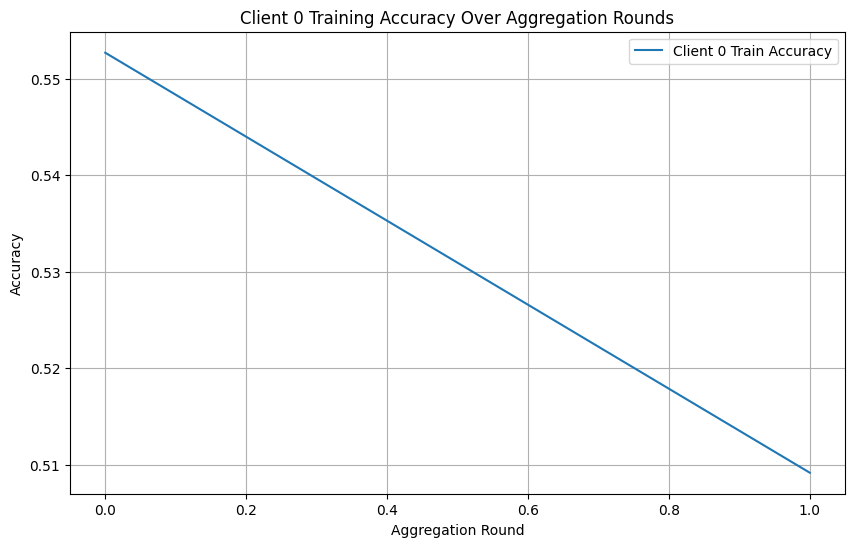

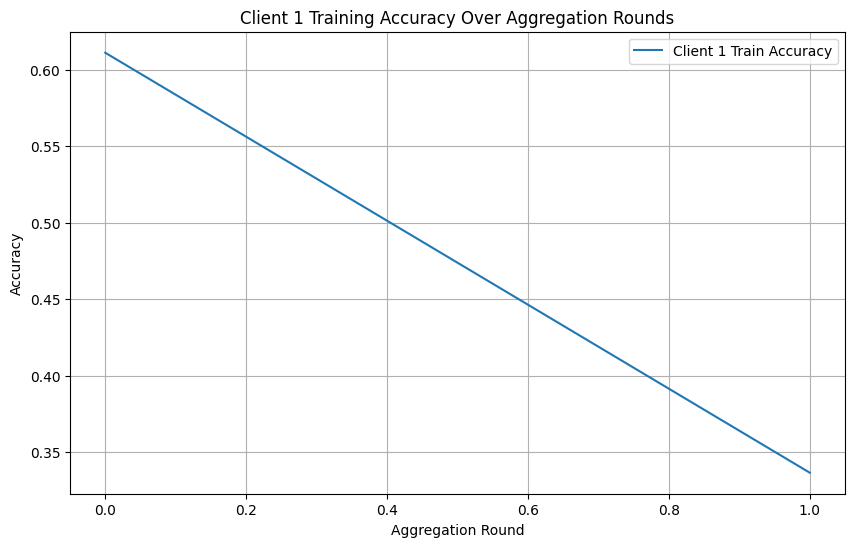

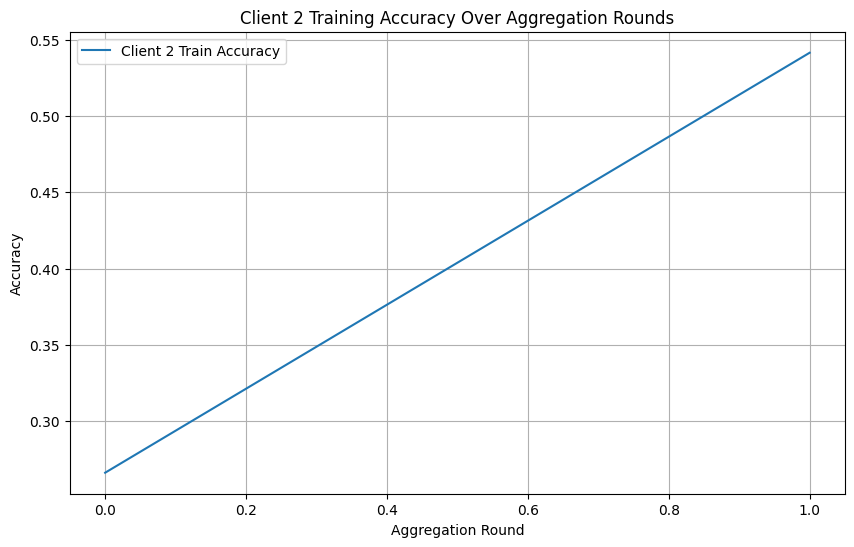

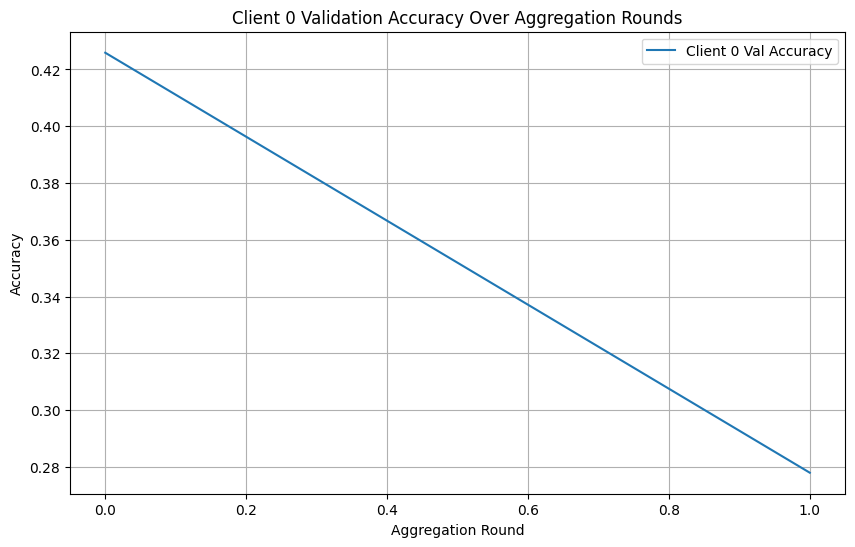

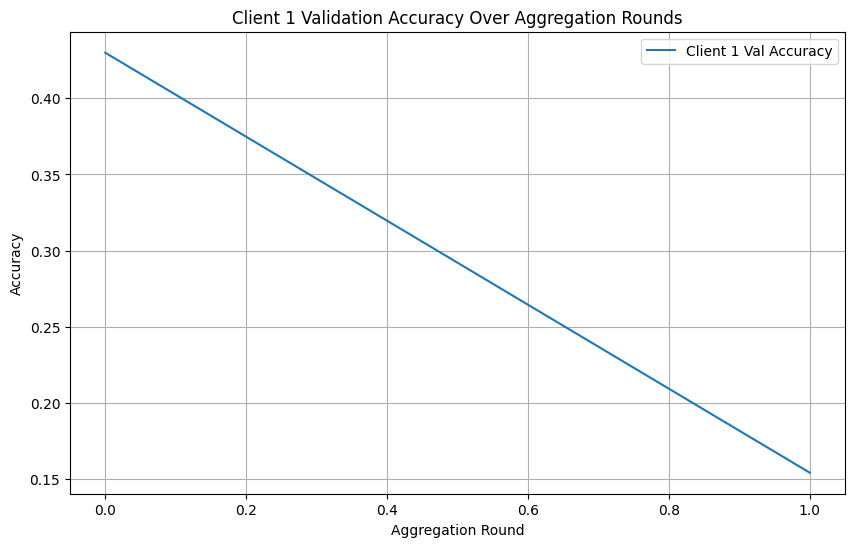

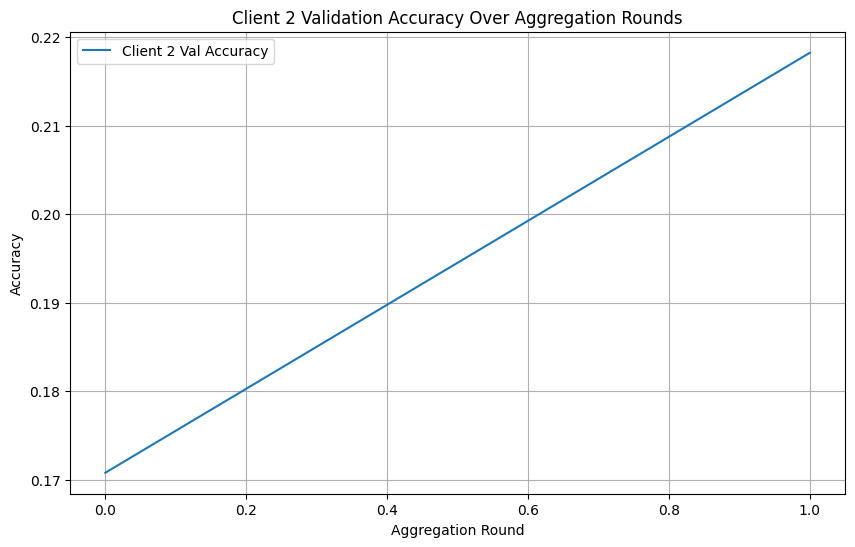

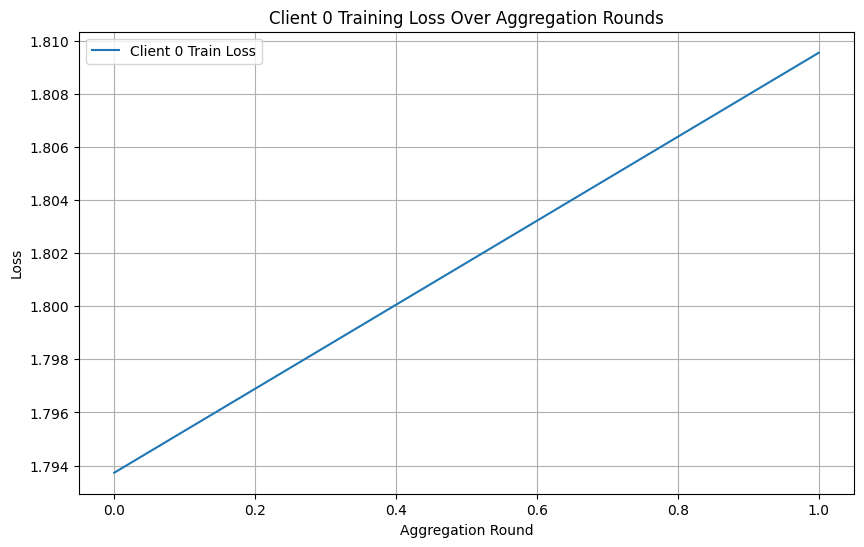

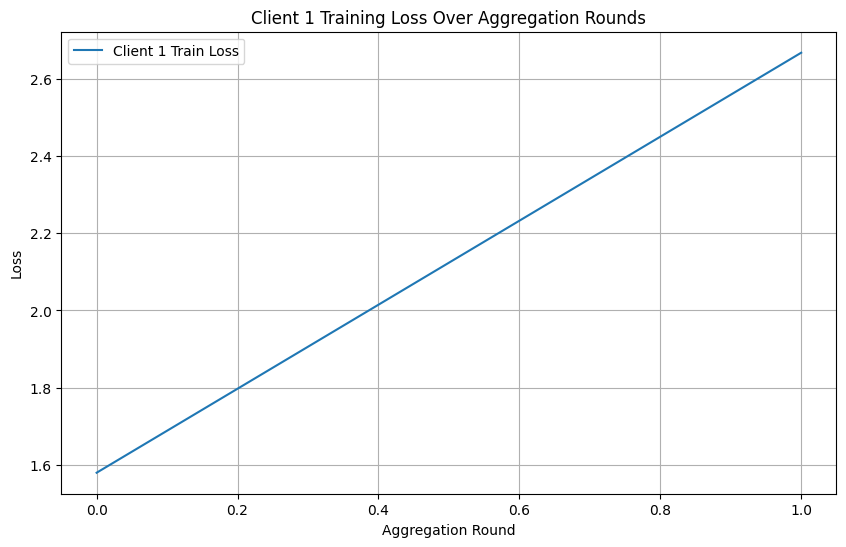

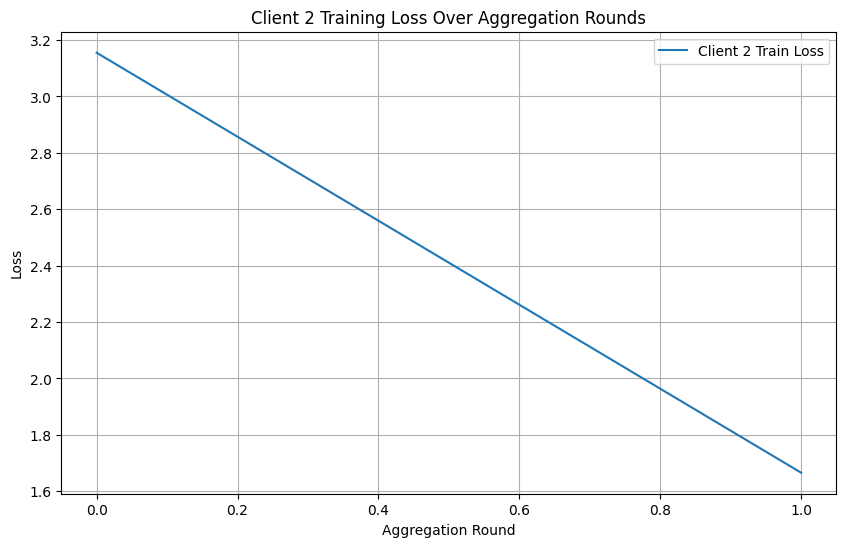

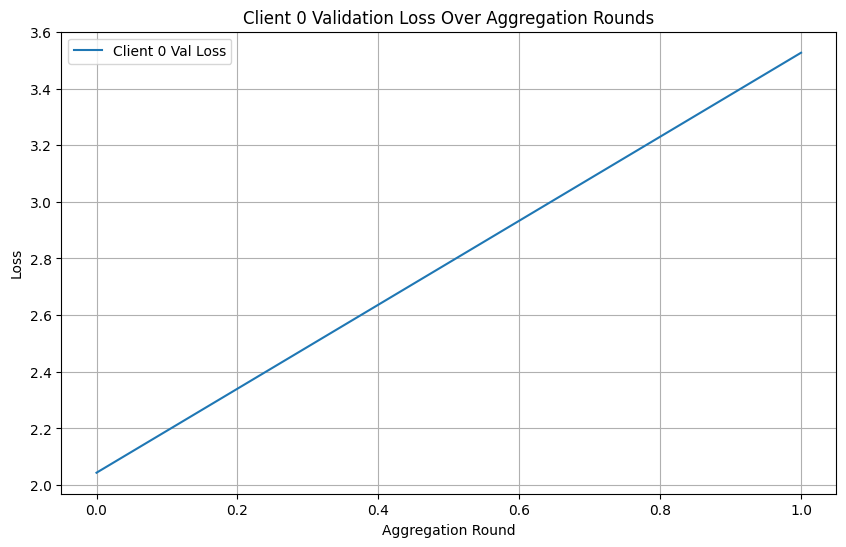

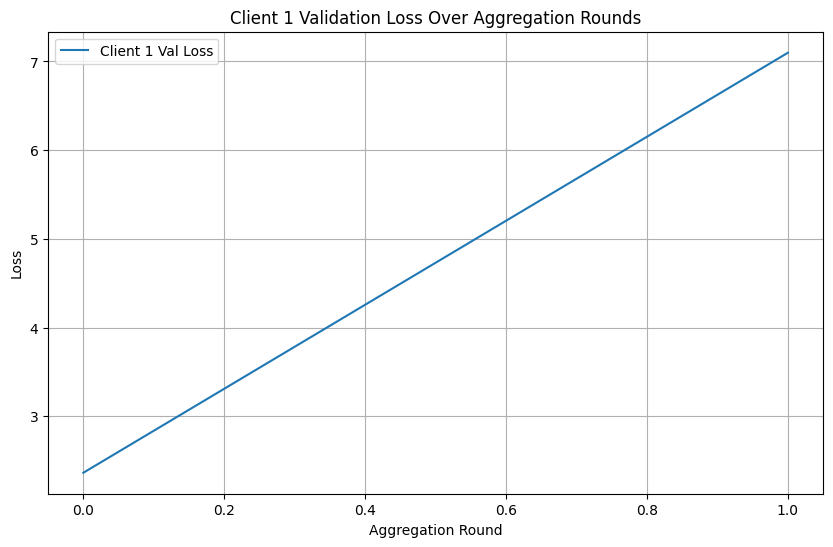

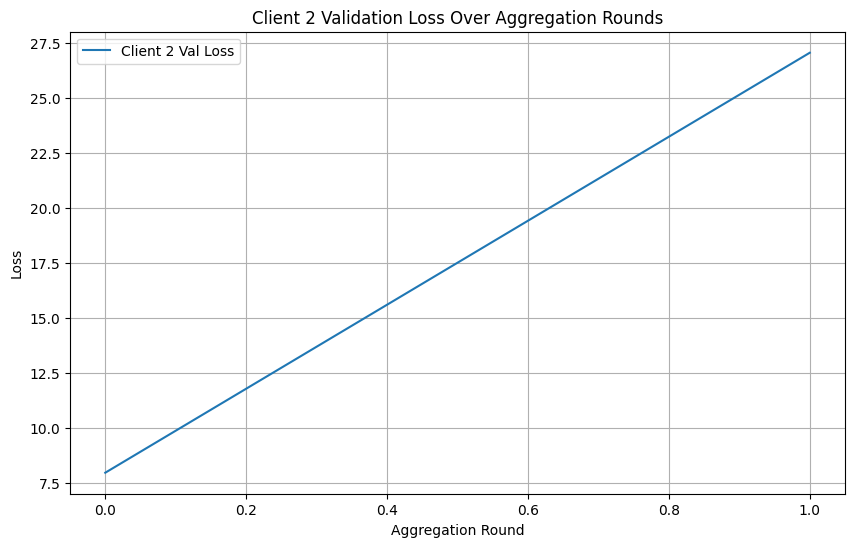

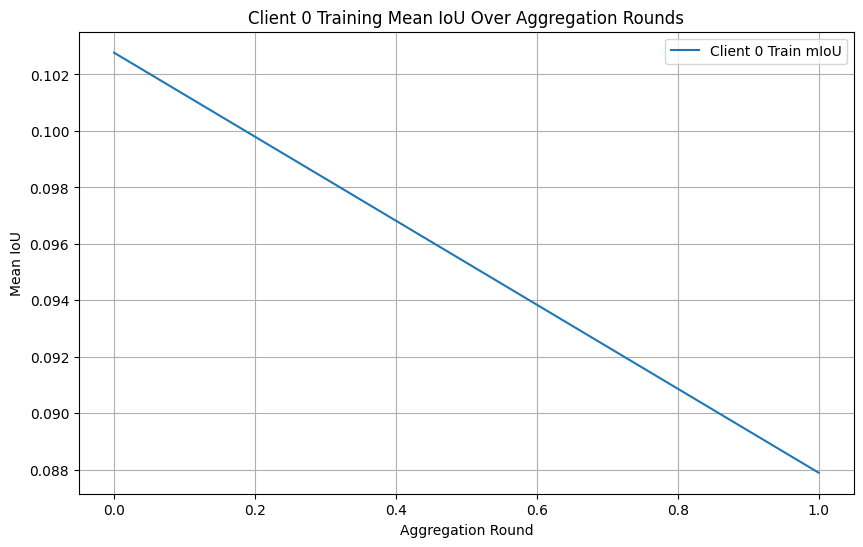

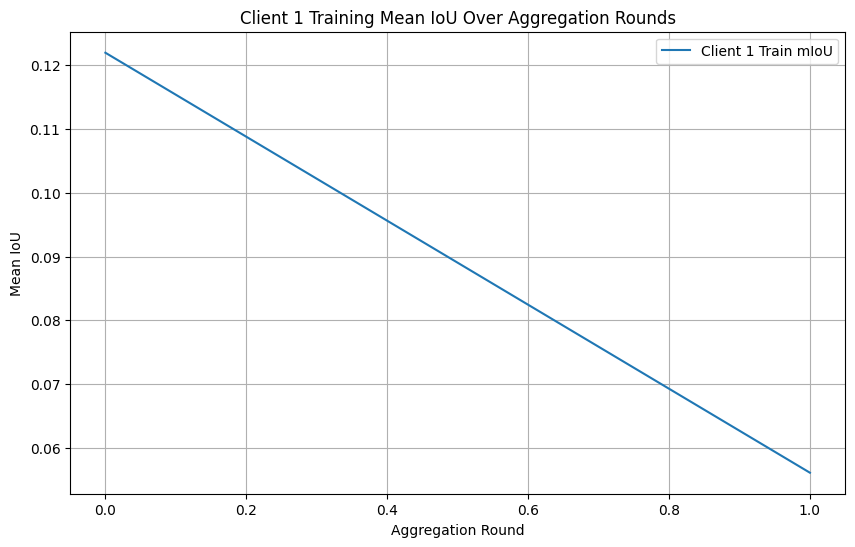

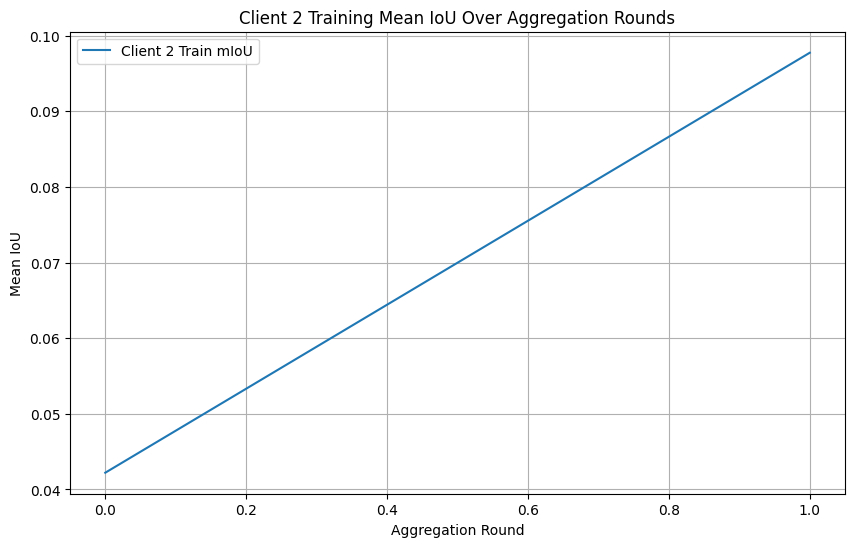

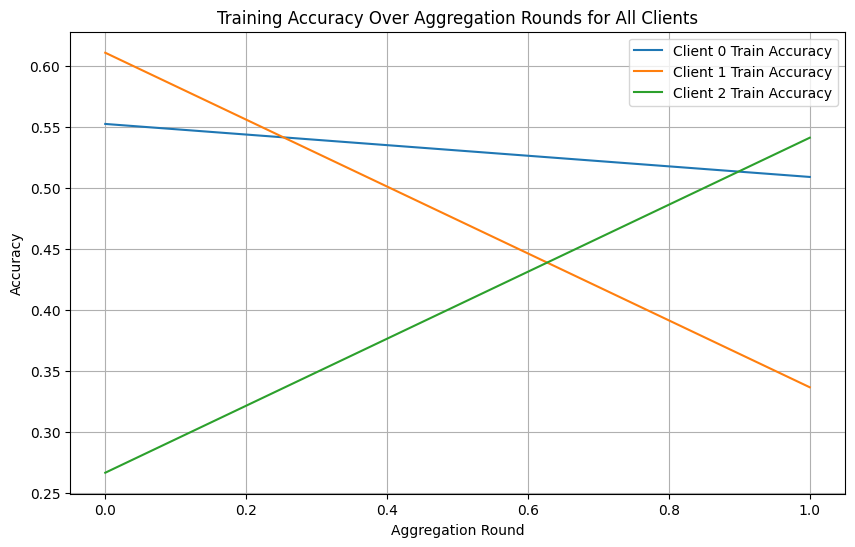

Aggregation Round 1 histories:
  Client 0: {'train_loss': [1.793729198913948], 'val_loss': [2.043490025732252], 'train_miou': [0.1027712571433207], 'val_miou': [0.08160818892167893], 'train_acc': [0.5526871636653974], 'val_acc': [0.42590948547979796], 'lrs': [0.0003999999999999993, 0.00042700970536526696, 0.0005077348530511047, 0.0006412669587014461, 0.0008261032461369475, 0.001060163559664094, 0.001340813774238685, 0.0016648954400247402, 0.0020287613277276094, 0.0024283164746725684, 0.0028590642696945546, 0.0033161570581976144, 0.003794450697872558, 0.004288562451100344, 0.004792931562517556, 0.005301881840001393, 0.005809685534785018, 0.006310627801793639, 0.006799071014761876, 0.007269518212327256, 0.007716674961074713, 0.008135508939322678, 0.008521306571092223, 0.008869726072898045, 0.009176846316370443, 0.009439210956806126, 0.009653867331023245, 0.009818399686762477, 0.009930956369669001, 0.0099902706618919, 0.009999225626708713, 0.009990516681618647, 0.009972147738762083, 0.009

In [ ]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store accuracies, losses, and mIoU for each client
train_accuracies = {i: [] for i in range(no_clients)}
val_accuracies = {i: [] for i in range(no_clients)}
train_losses = {i: [] for i in range(no_clients)}
val_losses = {i: [] for i in range(no_clients)}
train_miou = {i: [] for i in range(no_clients)}
val_miou = {i: [] for i in range(no_clients)}

# Populate the dictionaries with data from histories
for epoch_histories in histories:
	for i, history in enumerate(epoch_histories):
		train_accuracies[i].append(history["train_acc"][-1])
		val_accuracies[i].append(history["val_acc"][-1])
		train_losses[i].append(history["train_loss"][-1])
		val_losses[i].append(history["val_loss"][-1])
		train_miou[i].append(history["train_miou"][-1])
		val_miou[i].append(history["val_miou"][-1])

# Plotting training accuracy for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Accuracy")
	plt.title(f"Client {i} Training Accuracy Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting validation accuracy for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Accuracy")
	plt.title(f"Client {i} Validation Accuracy Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting training loss for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_losses[i], label=f"Client {i} Train Loss")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Loss")
	plt.title(f"Client {i} Training Loss Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting validation loss for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(val_losses[i], label=f"Client {i} Val Loss")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Loss")
	plt.title(f"Client {i} Validation Loss Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting mean IoU for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_miou[i], label=f"Client {i} Train mIoU")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Mean IoU")
	plt.title(f"Client {i} Training Mean IoU Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting all clients together for training accuracy
plt.figure(figsize=(10, 6))
for i in range(no_clients):
	plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
plt.xlabel("Aggregation Round")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Aggregation Rounds for All Clients")
plt.legend()
plt.grid(True)
plt.show()

# Display the detailed history for each client and each aggregation round
for e, epoch_histories in enumerate(histories):
	print(f"Aggregation Round {e+1} histories:")
	for i, history in enumerate(epoch_histories):
		print(f"  Client {i}: {history}")

In [ ]:
class DroneTestDataset(Dataset):

	def __init__(self, img_path, mask_path, X, transform=None):
		self.img_path = img_path
		self.mask_path = mask_path
		self.X = X
		self.transform = transform

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
		mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

		img = cv2.imread(img_full_path)
		if img is None:
			raise FileNotFoundError(f"Image not found at {img_full_path}")

		mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
		if mask is None:
			raise FileNotFoundError(f"Mask not found at {mask_full_path}")

		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			aug = self.transform(image=img, mask=mask)
			img = Image.fromarray(aug["image"])
			mask = aug["mask"]

		if self.transform is None:
			img = Image.fromarray(img)

		mask = torch.from_numpy(mask).long()

		return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_miou(
	model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
	model.eval()
	t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
	image = t(image)
	model.to(device)
	image = image.to(device)
	mask = mask.to(device)
	with torch.no_grad():

		image = image.unsqueeze(0)
		mask = mask.unsqueeze(0)

		output = model(image)
		score = mIoU(output, mask)
		masked = torch.argmax(output, dim=1)
		masked = masked.cpu().squeeze(0)
	return masked, score

In [ ]:
def predict_image_mask_pixel(
	model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
	model.eval()
	t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
	image = t(image)
	model.to(device)
	image = image.to(device)
	mask = mask.to(device)
	with torch.no_grad():

		image = image.unsqueeze(0)
		mask = mask.unsqueeze(0)

		output = model(image)
		acc = pixel_accuracy(output, mask)
		masked = torch.argmax(output, dim=1)
		masked = masked.cpu().squeeze(0)
	return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
	score_iou = []
	for i in tqdm(range(len(test_set))):
		img, mask = test_set[i]
		pred_mask, score = predict_image_mask_miou(model, img, mask)
		score_iou.append(score)
	return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


In [ ]:
def pixel_acc(model, test_set):
	accuracy = []
	for i in tqdm(range(len(test_set))):
		img, mask = test_set[i]
		pred_mask, acc = predict_image_mask_pixel(model, img, mask)
		accuracy.append(acc)
	return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


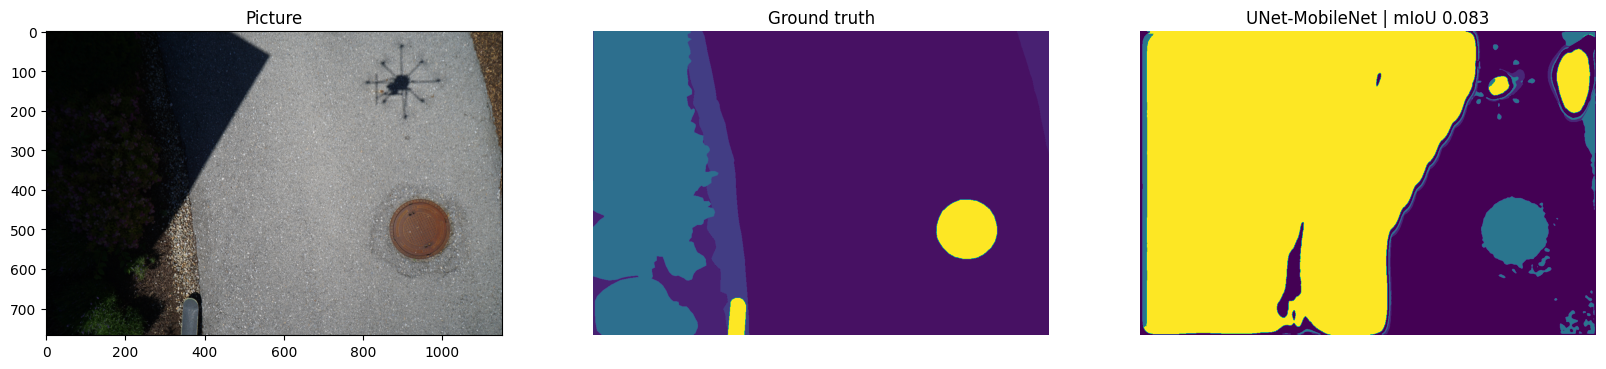

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title("Picture")

ax2.imshow(mask)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title("UNet-MobileNet | mIoU {:.3f}".format(score))
ax3.set_axis_off()

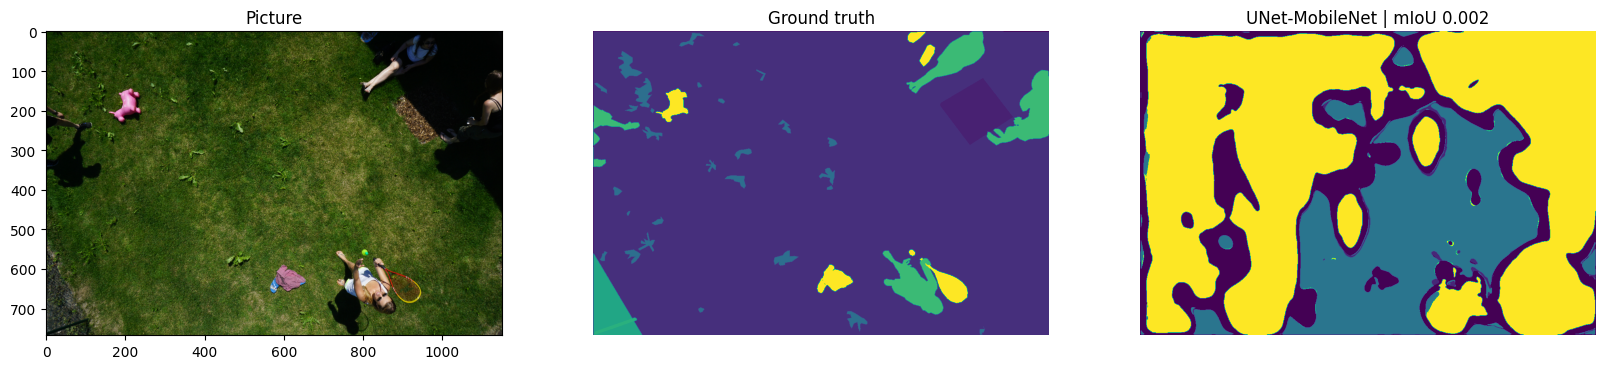

In [ ]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image3)
ax1.set_title("Picture")

ax2.imshow(mask3)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title("UNet-MobileNet | mIoU {:.3f}".format(score3))
ax3.set_axis_off()

In [ ]:
print("Test Set mIoU", np.mean(mob_miou))

Test Set mIoU 0.04423673845244817


In [ ]:
print("Test Set Pixel Accuracy", np.mean(mob_acc))

Test Set Pixel Accuracy 0.2563554834436487
